# Load Data

In [11]:
from data import get_mnist_dataloaders
import torch

from diffusion.transition import (
    linear_beta_schedule,
    build_all_transition_matrices,
    compute_cumulative_transition_matrices
)

import torch

In [3]:
train_loader, test_loader = get_mnist_dataloaders(
    batch_size=32,
    data_root="./data",
    threshold=0.5
)

In [ ]:
# Shape is (batch_size, channels, height, width)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [9]:
# Black or white pixels rather than greyscale
print(torch.unique(x))

tensor([0, 1])


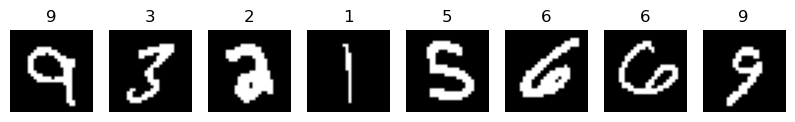

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(x[i].squeeze(), cmap="gray", vmin=0, vmax=1)
    plt.title(y[i].item())
    plt.axis("off")
plt.show()

# Define Transition Matrix for noising

In [12]:
T = 100

betas = linear_beta_schedule(T)
Qs = build_all_transition_matrices(betas)

print(betas.shape)   # torch.Size([100])
print(Qs.shape)       # torch.Size([100, 2, 2])
print(Qs[0])

torch.Size([100])
torch.Size([100, 2, 2])
tensor([[9.9990e-01, 1.0000e-04],
        [1.0000e-04, 9.9990e-01]])


In [ ]:
# Define Qbar[t] = Q_1 * Q_2 * ... * Q_t

